# Some tests

In [127]:
from data import ClasslessImageDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from glob import glob
from time import time
import numpy as np
from collections import OrderedDict
import timm
import segmentation_models_pytorch as smp
from sklearn.preprocessing import MinMaxScaler

In [36]:
!nvidia-smi

Tue Mar 22 11:51:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.79       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:26:00.0  On |                  N/A |
|  0%   45C    P8    24W / 220W |   1857MiB /  8192MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

____________________
____________________
# Setup image loaders

In [145]:
DATA_DIR = "D:\portrait"
BATCH_SIZE = 8
IMG_SIZE = (256, 256)

In [146]:
train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMG_SIZE),
    transforms.ConvertImageDtype(torch.float),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMG_SIZE),
    transforms.ConvertImageDtype(torch.float),
])

target_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ConvertImageDtype(torch.float),
])

In [147]:
train_ds = ClasslessImageDataset(DATA_DIR, split="train", transform=train_transforms, target_transform=target_transforms)
test_ds = ClasslessImageDataset(DATA_DIR, split="test", transform=test_transforms, target_transform=target_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

### View some exemplary images

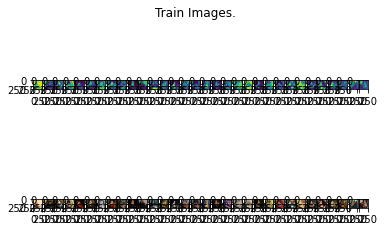

In [6]:
# train images
source, target = next(iter(train_loader))

fig, axs = plt.subplots(2, BATCH_SIZE)
fig.suptitle('Train Images.')
for i in range(BATCH_SIZE):
    axs[0,i].imshow(source[i].permute([1,2,0]))
    axs[1,i].imshow(target[i].permute([1,2,0]))

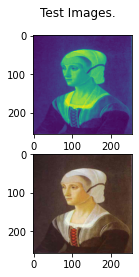

In [7]:
# test images
source, target = next(iter(test_loader))

fig, axs = plt.subplots(2, 1)
fig.suptitle('Test Images.')
axs[0].imshow(source[0].permute([1,2,0]))
axs[1].imshow(target[0].permute([1,2,0]))

In [8]:
# time dataloading
# train_ds.transform = None; train_ds.target_transform = None
# train_ds = ClasslessImageDataset(DATA_DIR, split="train", transform=train_transforms, target_transform=target_transforms)
img_iter = iter(train_loader)

n = 10
t = 0
for i in range(n):
    t0 = time()
    i1, i2 = next(img_iter)
#     i1 = i1.cuda(); i2 = i2.cuda()
    t1 = time()
    t += (t1-t0)
    
    print(i, t1-t0)
print(t, t/n)

0 1.4873535633087158
1 1.129028558731079
2 1.3572347164154053
3 1.3472273349761963
4 1.1370348930358887
5 1.6745238304138184
6 1.2951786518096924
7 1.0309388637542725
8 1.2791645526885986
9 1.2571446895599365
12.994829654693604 1.2994829654693603


______
______
# Setup model

In [6]:
# model = nn.Sequential(OrderedDict([
#     ("conv1", nn.Conv2d(1, 32, 3, padding=1, padding_mode="reflect")),
#     ("conv2", nn.Conv2d(32, 64, 3, padding=1, padding_mode="reflect")),
#     ("conv3", nn.Conv2d(64, 64, 3, padding=1, padding_mode="reflect")),
#     ("conv4", nn.Conv2d(64, 3, 3, padding=1, padding_mode="reflect")),
# #     nn.ReLU(),
#     ("sigm", nn.Sigmoid()),
# ])).cuda()

# model = nn.Sequential(OrderedDict([
#     ("conv1", nn.Conv2d(1, 64, 3, padding=1, padding_mode="reflect")),
#     ("conv2", nn.Conv2d(64, 3, 1, padding=0, padding_mode="reflect")),
# #     ("sigm", nn.Sigmoid()),
# ])).cuda()

model = nn.Sequential(OrderedDict([
    ("conv1", nn.Conv2d(1, 1, 3, padding=1, padding_mode="reflect")),
    ("flatten1", nn.Flatten()),
    ("linear1", nn.Linear(IMG_SIZE[0]*IMG_SIZE[1], IMG_SIZE[0]*IMG_SIZE[1]*3)),
    ("unflatten1", nn.Unflatten(1, (3, IMG_SIZE[0], IMG_SIZE[1])))
])).cuda()

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            10
├─Flatten: 1-2                           --
├─Linear: 1-3                            300,030,000
├─Unflatten: 1-4                         --
Total params: 300,030,010
Trainable params: 300,030,010
Non-trainable params: 0

tensor(63254.2891, grad_fn=<SumBackward0>)

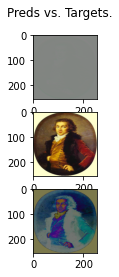

In [9]:
source, target = next(iter(test_loader))
model.eval()
preds = model(source.cuda()).cpu()
fig, axs = plt.subplots(3, 1)
fig.suptitle('Preds vs. Targets.')
axs[0].imshow(preds[0].detach().permute([1,2,0]).numpy())
axs[1].imshow(target[0].permute([1,2,0]))
axs[2].imshow((preds[0].detach().clamp(0,1)-target[0]).abs().permute([1,2,0]))
torch.abs(preds-target).sum()

In [10]:
preds

tensor([[[[0.5165, 0.5165, 0.5165,  ..., 0.5165, 0.5165, 0.5165],
          [0.5165, 0.5165, 0.5165,  ..., 0.5165, 0.5165, 0.5165],
          [0.5165, 0.5165, 0.5165,  ..., 0.5165, 0.5165, 0.5165],
          ...,
          [0.5165, 0.5165, 0.5165,  ..., 0.5165, 0.5165, 0.5165],
          [0.5165, 0.5165, 0.5165,  ..., 0.5165, 0.5165, 0.5165],
          [0.5165, 0.5165, 0.5165,  ..., 0.5165, 0.5165, 0.5165]],

         [[0.5280, 0.5280, 0.5280,  ..., 0.5280, 0.5280, 0.5280],
          [0.5280, 0.5280, 0.5280,  ..., 0.5280, 0.5280, 0.5280],
          [0.5280, 0.5280, 0.5280,  ..., 0.5280, 0.5280, 0.5280],
          ...,
          [0.5280, 0.5280, 0.5280,  ..., 0.5280, 0.5280, 0.5280],
          [0.5280, 0.5280, 0.5280,  ..., 0.5280, 0.5280, 0.5280],
          [0.5280, 0.5280, 0.5280,  ..., 0.5280, 0.5280, 0.5280]],

         [[0.5168, 0.5168, 0.5168,  ..., 0.5168, 0.5168, 0.5168],
          [0.5168, 0.5168, 0.5168,  ..., 0.5168, 0.5168, 0.5168],
          [0.5168, 0.5168, 0.5168,  ..., 0

In [22]:
# time model inference
n = 10
t = 0
i1, i2 = next(img_iter)
i1 = i1.cuda(); i2 = i2.cuda()

model.eval()
with torch.no_grad():
    for i in range(n):
        t0 = time()
        p = model(i1)
        t1 = time()
        t += (t1-t0)

        print(i, t1-t0)
    print(t, t/n)

0 0.0020017623901367188
1 0.0010008811950683594
2 0.002001523971557617
3 0.0010013580322265625
4 0.002001523971557617
5 0.0010013580322265625
6 0.0010001659393310547
7 0.0010004043579101562
8 0.0010008811950683594
9 0.0020020008087158203
0.014011859893798828 0.0014011859893798828


____
____
# Overfit model to test functionality

In [9]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [152]:
# Setup model, loss and optimizer

model = nn.Sequential(
    smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
#     activation = "sigmoid",
    ),
    nn.LayerNorm([3, IMG_SIZE[0], IMG_SIZE[1]]),
).cuda()

In [154]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [155]:
data = next(iter(train_loader))
src, tgt = data[0].cuda(), data[1].cuda()
src, tgt = src[:2], tgt[:2]

<IPython.core.display.Javascript object>


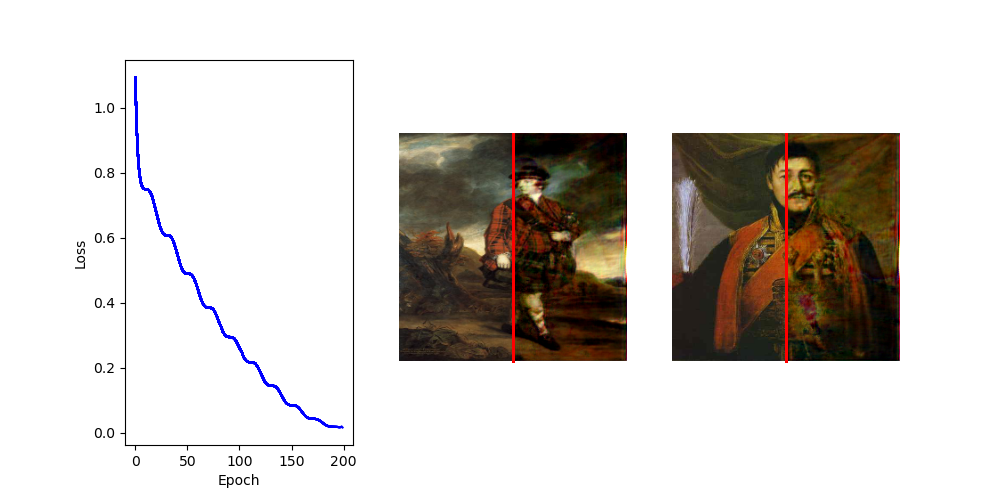

  0%|          | 0/200 [00:00<?, ?it/s]

In [156]:
%matplotlib notebook

fig, axs = plt.subplots(1, 3, figsize = (10,5))
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].axis("off")
axs[2].axis("off")

fig.show()
fig.canvas.draw()

N_EPOCHS = 200
loss_per_epoch = []
for i in tqdm(range(N_EPOCHS)):
    optimizer.zero_grad()
    preds = model(src)
    
#     loss = torch.sum(torch.abs(preds-tgt))
    loss = loss_function(preds, tgt)
    loss.backward()
    
    optimizer.step()
    scheduler.step()
    
    loss_per_epoch.append(loss.item())
    
    axs[0].plot(loss_per_epoch, "b")
    if i%10 == 0:
        
        for e in range(2):
            img = tgt[e].detach().cpu().permute([1,2,0]).numpy()
            img[:, IMG_SIZE[0]//2:] = preds[e].detach().cpu().permute([1,2,0]).numpy()[:, IMG_SIZE[1]//2:]
            axs[e+1].imshow(img.clip(0,1))
#             axs[e+1].imshow(MinMaxScaler(img))

            lx, ly  = [IMG_SIZE[0]//2, IMG_SIZE[0]//2], [0, IMG_SIZE[1]]
            axs[e+1].plot(lx, ly, "r",linewidth=2)

    fig.canvas.draw()

____
____
# Create Train Loop

In [157]:
model = nn.Sequential(
    smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
    ),
    nn.LayerNorm([3, IMG_SIZE[0], IMG_SIZE[1]]),
).cuda()

In [158]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [161]:
test_iter_demo = iter(test_loader)
data1 = next(test_iter_demo)
data2 = next(test_iter_demo)
src_demo1, tgt_demo1 = data1[0].cuda(), data1[1].cuda()
src_demo2, tgt_demo2 = data2[0].cuda(), data2[1].cuda()
src_demo, tgt_demo = torch.cat([src_demo1, src_demo2], dim=0), torch.cat([tgt_demo1, tgt_demo2], dim=0)

<IPython.core.display.Javascript object>


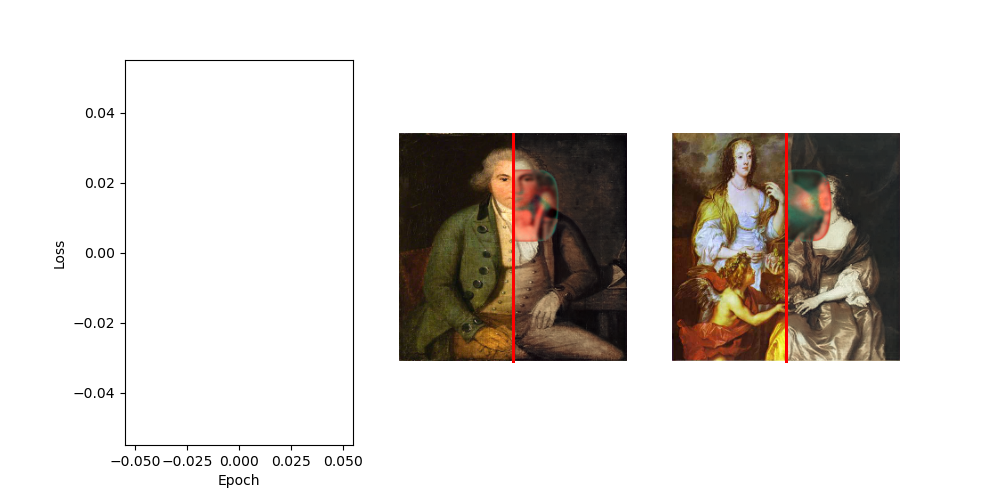

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1609 [00:00<?, ?it/s]

train 1 134.3063722886145


0it [00:00, ?it/s]

test 1 53251174.279785156


  0%|          | 0/1609 [00:00<?, ?it/s]

train 1 36.26710689533502


0it [00:00, ?it/s]

test 1 41926776.865234375


  0%|          | 0/1609 [00:00<?, ?it/s]

train 1 21.361204612534493


0it [00:00, ?it/s]

test 1 29335003.326660156


  0%|          | 0/1609 [00:00<?, ?it/s]

train 1 17.044826188590378


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [162]:
N_EPOCHS = 10


%matplotlib notebook
fig, axs = plt.subplots(1, 3, figsize = (10,5))
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].axis("off")
axs[2].axis("off")


loss_per_epoch = []
for e in tqdm(range(N_EPOCHS)):
    
    train_loss = 0
    model.train()
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_ds)//BATCH_SIZE):
        src, tgt = data
        src = src.cuda(); tgt = tgt.cuda()
        
        optimizer.zero_grad()
        preds = model(src)
        loss = loss_function(preds, tgt)
#         loss = torch.sum(torch.abs(preds-tgt))
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        
        if i%20 == 0:
            preds = model(src_demo)
            for e in range(2):
                img = tgt_demo[e].detach().cpu().permute([1,2,0]).numpy()
                img[:, IMG_SIZE[0]//2:] = preds[e].detach().cpu().permute([1,2,0]).numpy()[:, IMG_SIZE[1]//2:]
                axs[e+1].imshow(img.clip(0,1))

                lx, ly  = [IMG_SIZE[0]//2, IMG_SIZE[0]//2], [0, IMG_SIZE[1]]
                axs[e+1].plot(lx, ly, "r",linewidth=2)
                
            fig.canvas.draw()
        
    print("train", e, np.mean(train_loss))
    loss_per_epoch += np.mean(train_loss)
    
    axs[0].plot(loss_per_epoch, "b")
    fig.canvas.draw()
    
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader, 0)):
            src, tgt = data
            src = src.cuda(); tgt = tgt.cuda()

            preds = model(src)
#             loss = loss_function(preds, tgt)
            loss = torch.sum(torch.abs(preds-tgt))
            test_loss += loss.item()
            
#             print("Test", loss)
    print("test", e, np.mean(test_loss))
            

In [13]:
model.to("cpu")

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv4): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (sigm): Sigmoid()
)

In [189]:
data = next(iter(train_loader))

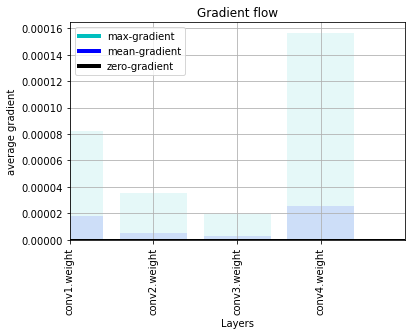

In [245]:
plot_grad_flow(model.named_parameters())

In [80]:
model = smp.Unet(
    encoder_name="tu-efficientnetv2_m",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
).cuda()

No pretrained weights exist for this model. Using random initialization.


In [77]:
summary(model)

Layer (type:depth-idx)                                  Param #
Unet                                                    --
├─TimmUniversalEncoder: 1-1                             --
│    └─EfficientNetFeatures: 2-1                        --
│    │    └─Conv2d: 3-1                                 216
│    │    └─BatchNorm2d: 3-2                            48
│    │    └─SiLU: 3-3                                   --
│    │    └─Sequential: 3-4                             52,199,740
├─UnetDecoder: 1-2                                      --
│    └─Identity: 2-2                                    --
│    └─ModuleList: 2-3                                  --
│    │    └─DecoderBlock: 3-5                           2,176,000
│    │    └─DecoderBlock: 3-6                           535,040
│    │    └─DecoderBlock: 3-7                           138,496
│    │    └─DecoderBlock: 3-8                           34,688
│    │    └─DecoderBlock: 3-9                           6,976
├─SegmentationHead

In [24]:
model.named_parameters

<bound method Module.named_parameters of Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, ep

In [33]:
t = torch.rand(size=(1,1,512,512))

In [51]:
model(t).shape

torch.Size([1, 3, 512, 512])

In [11]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n